<a href="https://colab.research.google.com/github/AdminMas7er/JBG040-DC1-Group-14/blob/main/Data_Challenge_1_Group_14_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction:
In this template, methods are provided to get you started on the task at hand (please see project description). Please implement your solution in the code cells marked with **TODO**. Most of the other code cells are hidden, feel free to explore and change these. These cells implement a basic pipeline for training your model but you may want to explore more complex procedures. **Make sure you run all cells before trying to implement your own solution!**



#Imports and definitions:

In [17]:
#@title
import numpy as np
import requests
import io
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import rotate
%matplotlib inline
from torch.utils.data import Dataset
import random
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm

class BatchSampler():
  """
  Implements an iterable which given a torch dataset and a batch_size
  will produce batches of data of that given size. The batches are
  returned as tuples in the form (images, labels).
  Can produce balanced batches, where each batch will have an equal 
  amount of samples from each class in the dataset. If your dataset is heavily
  imbalanced, this might mean throwing away a lot of samples from 
  over-represented classes!
  """

  def __init__(self, batch_size, dataset, balanced=False):
    self.batch_size = batch_size
    self.dataset = dataset
    self.balanced = balanced
    if self.balanced:
      # Counting the ocurrence of the class labels:
      unique, counts = np.unique(self.dataset.targets, return_counts=True) 
      indexes = []
      # Sampling an equal amount from each class:
      for i in range(len(unique)):
        indexes.append(np.random.choice(np.where(self.dataset.targets == i)[0], size=counts.min(), replace=False))
      # Setting the indexes we will sample from later:
      self.indexes = np.concatenate(indexes)
    else:
      # Setting the indexes we will sample from later (all indexes):
      self.indexes = [i for i in range(len(dataset))]


  def __len__(self):
    return (len(self.indexes) // self.batch_size) + 1
  
  def shuffle(self):
    # We do not need to shuffle if we use the balanced sampling method.
    # Shuffling is already done when making the balanced samples.
    if not self.balanced:
      random.shuffle(self.indexes)
    
  def __iter__(self):
    remaining = False
    self.shuffle()
    # Go over the datset in steps of 'self.batch_size':
    for i in range(0, len(self.indexes), self.batch_size):
        imgs, labels = [], []
        # If our current batch is larger than the remaining data, we quit:
        if i + self.batch_size > len(self.indexes):
          remaining = True
          break
        # If not, we yield a complete batch:
        else:
          # Getting a list of samples from the dataset, given the indexes we defined:
          X_batch = [self.dataset[self.indexes[k]][0] for k in range(i, i + self.batch_size)]
          Y_batch = [self.dataset[self.indexes[k]][1] for k in range(i, i + self.batch_size)]
          # Stacking all the samples and returning the target labels as a tensor:
          yield torch.stack(X_batch).float(), torch.tensor(Y_batch).long()
    # If there is still data left that was not a full batch:
    if remaining:
      # Return the last batch (smaller than batch_size):
      X_batch = [self.dataset[self.indexes[k]][0] for k in range(i, len(self.indexes))]
      Y_batch = [self.dataset[self.indexes[k]][1] for k in range(i, len(self.indexes))]
      yield torch.stack(X_batch).float(), torch.tensor(Y_batch).long()

class ImageDataset(Dataset):
  """
  Creates a DataSet from numpy arrays while keeping the data 
  in the more efficient numpy arrays for as long as possible and only
  converting to torchtensors when needed (torch tensors are the objects used
  to pass the data through the neural network and apply weights).
  """
  
  def __init__(self, x, y, transform=None, target_transform=None):
    self.targets = y
    self.imgs = x
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    image = torch.from_numpy(self.imgs[idx] / 255).float()
    label = self.targets[idx]
    return image, label

def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 


class_labels = {0: 'Atelectasis',
                1: 'Effusion',
                2: 'Infiltration',
                3: 'No Finding',
                4: 'Nodule',
                5: 'Pneumothorax'}

In [18]:
import pandas as pd

models_df = pd.DataFrame()
run = 0

# Downloading the data:
The following cells will download the pre-processed X-ray images with their accompanying labels.

The download (400 MB) may take a while.

In [19]:
#@title
# Downloading the labels of each image:
train_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/i6MvQ8nqoiQ9Tci/download')
test_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/wLXiOjVAW4AWlXY/download')

In [20]:
#@title
# Downloading the images:
train_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4rwSf9SYO1ydGtK/download')
test_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/dvY2LpvFo6dHef0/download')

# Plotting the data distribution:

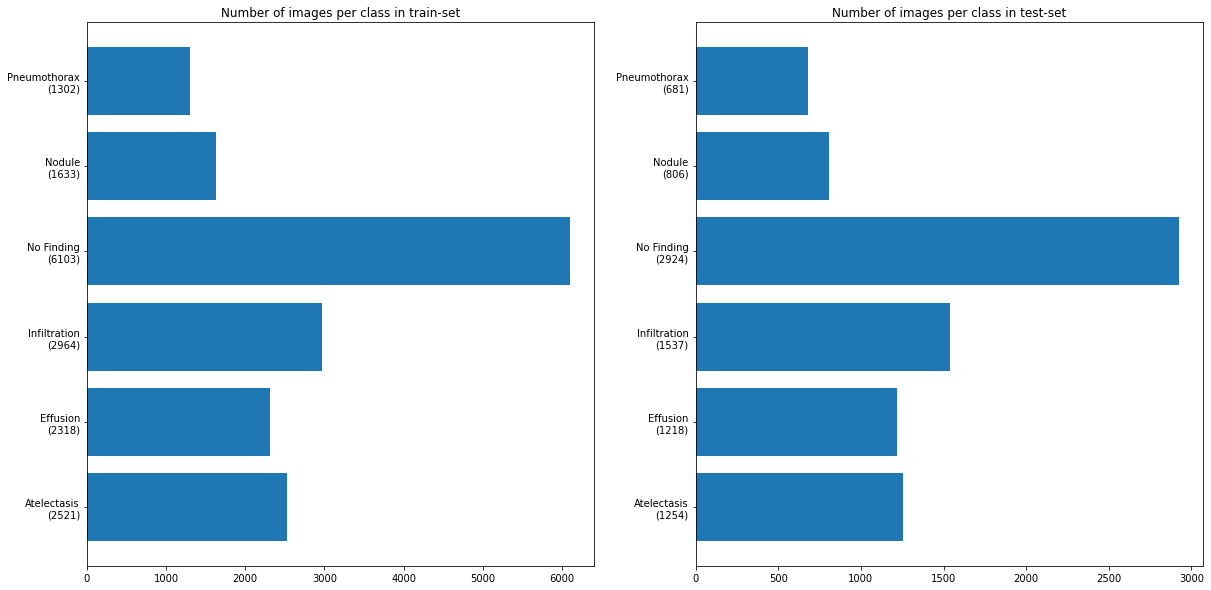

In [21]:
#@title
# Plotting the label distribution in train/test set:
fig, ax = plt.subplots(ncols=2, figsize=[20,10])

unique, counts = np.unique(train_y, return_counts=True) 
ax[0].barh([class_labels[i] + f'\n({c})' for i, c in zip(unique, counts)], counts)
ax[0].set_title('Number of images per class in train-set')

unique, counts = np.unique(test_y, return_counts=True) 
ax[1].barh([class_labels[i] + f'\n({c})' for i, c in zip(unique, counts)], counts)
ax[1].set_title('Number of images per class in test-set');

#Plotting some samples:

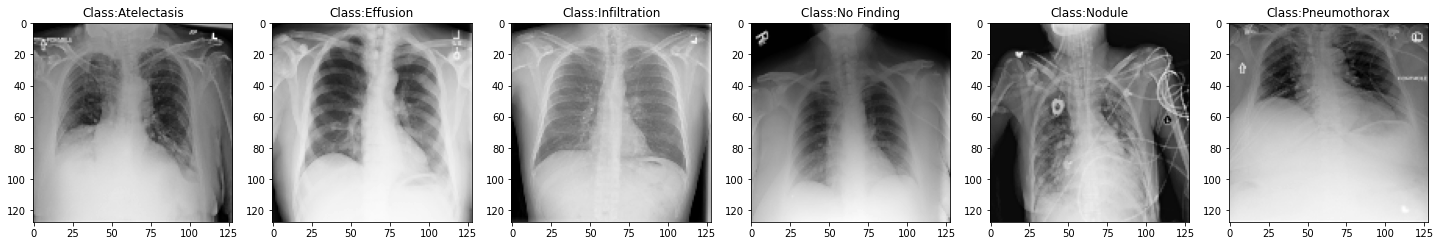

In [22]:
#@title
# Plotting some images
unique_labels = set(class_labels.keys())
fig, ax = plt.subplots(ncols=len(unique_labels), figsize=[25,5])

for k, label in enumerate(unique_labels):
  ind = list(train_y).index(label)
  ax[k].imshow(train_x[ind].reshape(128,128), cmap='gray')
  ax[k].set_title(f'Class:{class_labels[train_y[ind]]}')

# Building torch datasets:

In [45]:
#@title
train_dataset = ImageDataset(train_x, train_y)
test_dataset = ImageDataset(test_x, test_y)

# Defining our model as a neural network:
**TODO** define your own model here, follow the structure as presented in the Pytorch tutorial (or see below as an example).

In [46]:
class Net(nn.Module):   
    def __init__(self, n_classes):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 64, kernel_size=4, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4),
            torch.nn.Dropout(p=0.5, inplace=True),
            # Defining another 2D convolution layer
            nn.Conv2d(64, 32, kernel_size=4, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            torch.nn.Dropout(p=0.25, inplace=True),
            # Defining another 2D convolution layer
            nn.Conv2d(32, 16, kernel_size=4, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(p=0.125, inplace=True),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(144, 256),
            nn.Linear(256, n_classes)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        # After our convolutional layers which are 2D, we need to flatten our
        # input to be 1 dimensional, as the linear layers require this.
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

    def reset_parameters(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

# Make sure your model instance is assigned to a variable 'model':
model = Net(n_classes = 6)

# Defining our loss and optimizer functions:
**TODO** Please define your own optimizer and loss function. <br>

**Add to df**


In [47]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.1)
loss_function = nn.CrossEntropyLoss()

In [ ]:
loss_function=nn.KLDivLoss(reduction='mean')

In [ ]:
loss_function=nn.NLLLoss()

#Moving model to CUDA, verifying model structure and printing a summary:

In [48]:
# IMPORTANT! Set this to True to see actual errors regarding 
# the structure of your model (CUDA hides them)!
# Also make sure you set this to False again for actual model training
# as training your model with GPU-acceleration (CUDA) is much faster.
DEBUG = False

In [49]:
#@title
# Moving our model to the right device (CUDA will speed training up significantly!)
if torch.cuda.is_available() and not DEBUG:
  device = 'cuda'
  model.to(device)
  # Creating a summary of our model and its layers:
  summary(model, (1, 128, 128), device=device)

else:
  device='cpu'
  # Creating a summary of our model and its layers:
  summary(model, (1, 128, 128), device=device)
  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           1,088
       BatchNorm2d-2         [-1, 64, 125, 125]             128
              ReLU-3         [-1, 64, 125, 125]               0
         MaxPool2d-4           [-1, 64, 31, 31]               0
           Dropout-5           [-1, 64, 31, 31]               0
            Conv2d-6           [-1, 32, 28, 28]          32,800
       BatchNorm2d-7           [-1, 32, 28, 28]              64
              ReLU-8           [-1, 32, 28, 28]               0
         MaxPool2d-9             [-1, 32, 9, 9]               0
          Dropout-10             [-1, 32, 9, 9]               0
           Conv2d-11             [-1, 16, 6, 6]           8,208
      BatchNorm2d-12             [-1, 16, 6, 6]              32
             ReLU-13             [-1, 16, 6, 6]               0
        MaxPool2d-14             [-1, 1

#Defining our training/testing methods:

In [50]:
#!pip install -Uqq ipdb 
#to install the debugger


In [51]:
#import ipdb as pdb 

#this is to import it


In [52]:
#@title
def train_model(model, train_sampler, optimizer, loss_function):
  # Lets keep track of all the losses:
  losses = []
  # Put the model in train mode:
  model.train()
  # Feed all the batches one by one:
  for batch in tqdm(train_sampler):
    # Get a batch:
    x, y = batch
    # Making sure our samples are stored on the same device as our model: 
    x, y = x.to(device), y.to(device)
    # Get predictions:
    predictions = model.forward(x)
    loss = loss_function(predictions, y)
    losses.append(loss)
    # We first need to make sure we reset our optimizer at the start.
    # We want to learn from each batch seperately, 
    # not from the entire dataset at once.
    optimizer.zero_grad()
    # We now backpropagate our loss through our model:
    loss.backward()
    # We then make the optimizer take a step in the right direction.
    optimizer.step()
  return losses

def test_model(model, test_sampler, loss_function):
  # Setting the model to evaluation mode:
  model.eval()
  losses = []
  # We need to make sure we do not update our model based on the test data:
  with torch.no_grad():
    for (x, y) in tqdm(test_sampler):
      # Making sure our samples are stored on the same device as our model:
      x = x.to(device)
      y = y.to(device)
      prediction = model.forward(x)
      loss = loss_function(prediction, y)
      losses.append(loss)
  return losses

Copy of the train model with long or int for the KLDivLoss run this for KLDiv loss function


In [ ]:
#@title
def train_model(model, train_sampler, optimizer, loss_function):
  # Lets keep track of all the losses:
  losses = []
  # Put the model in train mode:
  model.train()
  # Feed all the batches one by one:
  for batch in tqdm(train_sampler):
    # Get a batch:
    x, y = batch
    #pdb.set_trace(context=100)
    # Making sure our samples are stored on the same device as our model: 
    x, y = x.to(device), y.to(device)
    # Get predictions:
    predictions = model.forward(x)
    loss = loss_function(predictions, y)
    loss=loss.to(torch.long)
    #pdb.set_trace(context=100)
    losses.append(loss)
    # We first need to make sure we reset our optimizer at the start.
    # We want to learn from each batch seperately, 
    # not from the entire dataset at once.
    #pdb.set_trace(context=100)
    optimizer.zero_grad()
    # We now backpropagate our loss through our model:
    #pdb.set_trace(context=100)
    loss=loss.to(torch.float)
    loss.requires_grad=True
    
    loss.backward()
    # We then make the optimizer take a step in the right direction.
    optimizer.step()
  return losses

def test_model(model, test_sampler, loss_function):
  # Setting the model to evaluation mode:
  model.eval()
  losses = []
  # We need to make sure we do not update our model based on the test data:
  with torch.no_grad():
    for (x, y) in tqdm(test_sampler):
      # Making sure our samples are stored on the same device as our model:
      x = x.to(device)
      y = y.to(device)
      prediction = model.forward(x)
      loss = loss_function(prediction, y)
      losses.append(loss)
  return losses

#Training our model:

In [53]:
n_epochs = 10 #change value to 1 for debugging reasons
batch_size = 25

100%|██████████| 674/674 [00:33<00:00, 20.18it/s]



Epoch 1 training done, loss on train set: 1.6670578718185425



100%|██████████| 85/85 [00:05<00:00, 14.83it/s]



Epoch 1 testing done, loss on test set: 1.655988335609436



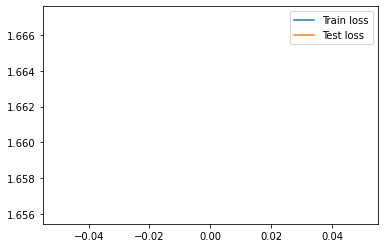

100%|██████████| 674/674 [00:33<00:00, 20.17it/s]



Epoch 2 training done, loss on train set: 1.6263427734375



100%|██████████| 85/85 [00:05<00:00, 14.85it/s]



Epoch 2 testing done, loss on test set: 1.6376444101333618



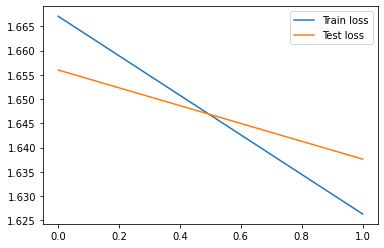

100%|██████████| 674/674 [00:33<00:00, 20.15it/s]



Epoch 3 training done, loss on train set: 1.6097527742385864



100%|██████████| 85/85 [00:05<00:00, 14.84it/s]



Epoch 3 testing done, loss on test set: 1.623003602027893



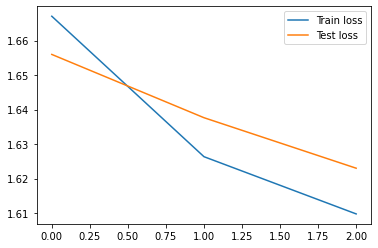

100%|██████████| 674/674 [00:33<00:00, 20.16it/s]



Epoch 4 training done, loss on train set: 1.5999529361724854



100%|██████████| 85/85 [00:05<00:00, 14.84it/s]



Epoch 4 testing done, loss on test set: 1.6163971424102783



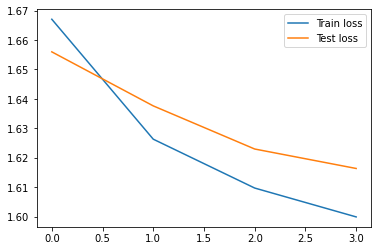

100%|██████████| 674/674 [00:33<00:00, 20.04it/s]



Epoch 5 training done, loss on train set: 1.5936168432235718



100%|██████████| 85/85 [00:05<00:00, 14.84it/s]



Epoch 5 testing done, loss on test set: 1.6079206466674805



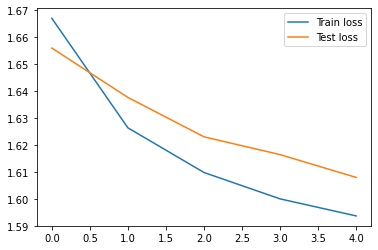

100%|██████████| 674/674 [00:33<00:00, 20.16it/s]



Epoch 6 training done, loss on train set: 1.5869873762130737



100%|██████████| 85/85 [00:05<00:00, 14.84it/s]



Epoch 6 testing done, loss on test set: 1.6027497053146362



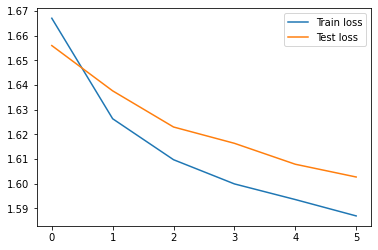

100%|██████████| 674/674 [00:33<00:00, 20.16it/s]



Epoch 7 training done, loss on train set: 1.5827796459197998



100%|██████████| 85/85 [00:05<00:00, 14.84it/s]



Epoch 7 testing done, loss on test set: 1.5972257852554321



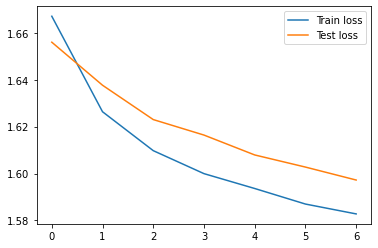

100%|██████████| 674/674 [00:33<00:00, 20.15it/s]



Epoch 8 training done, loss on train set: 1.5783252716064453



100%|██████████| 85/85 [00:05<00:00, 14.84it/s]



Epoch 8 testing done, loss on test set: 1.5979893207550049



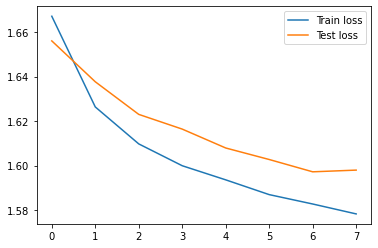

100%|██████████| 674/674 [00:33<00:00, 20.15it/s]



Epoch 9 training done, loss on train set: 1.5785237550735474



100%|██████████| 85/85 [00:05<00:00, 14.84it/s]



Epoch 9 testing done, loss on test set: 1.5936369895935059



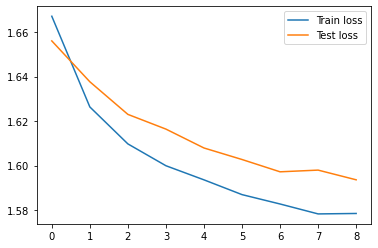

100%|██████████| 674/674 [00:33<00:00, 20.15it/s]



Epoch 10 training done, loss on train set: 1.574703574180603



100%|██████████| 85/85 [00:05<00:00, 14.84it/s]



Epoch 10 testing done, loss on test set: 1.5910102128982544



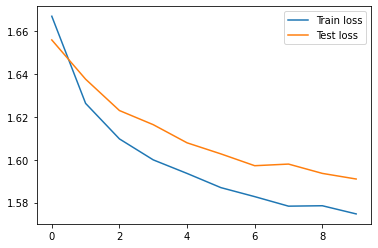

In [54]:
#@title
# Lets now train and test our model for multiple epochs:
train_sampler = BatchSampler(batch_size=batch_size, dataset=train_dataset, balanced=False)
test_sampler = BatchSampler(batch_size=100, dataset=test_dataset, balanced=False)

mean_losses_train = []
mean_losses_test = []
accuracies = []
for e in range(n_epochs):
  # Training:
  #pdb.set_trace(context=1000)
  losses = train_model(model, train_sampler, optimizer, loss_function)
  # Calculating and printing statistics:
  mean_loss = sum(losses) / len(losses)
  mean_losses_train.append(mean_loss)
  print(f'\nEpoch {e + 1} training done, loss on train set: {mean_loss}\n')

  # Testing:
  losses = test_model(model, test_sampler, loss_function)
  # Calculating and printing statistics:
  mean_loss = sum(losses) / len(losses)
  mean_losses_test.append(mean_loss)
  print(f'\nEpoch {e + 1} testing done, loss on test set: {mean_loss}\n')
  # Plotting the historic loss:
  fig, ax = plt.subplots()
  ax.plot(mean_losses_train, label='Train loss')
  ax.plot(mean_losses_test, label='Test loss')
  ax.legend()
  plt.show()

#Evaluation our model:
**TODO** write your own methods to evaluate the model. For example, calculate the accuracy of the model on the test-set:

## Accuracy

In [61]:
model.eval()
# We need to make sure we do not update our model based on the test data:
def calculate_accuracy():
  with torch.no_grad():
    correct = 0
    count = 0
    for (x, y) in tqdm(test_sampler):
      # Making sure our samples are stored on the same device as our model:
      x = x.to(device)
      y = y.to(device)
      prediction = model.forward(x).argmax(axis=1)
      correct += sum(prediction == y)
      count += len(y)
  accuracy = (correct/count).detach().cpu().numpy()
  print(f'\nAccuracy of model on test set: {accuracy}')
  return float(accuracy)

calculate_accuracy()

100%|██████████| 85/85 [00:05<00:00, 14.65it/s]


Accuracy of model on test set: 0.3703087866306305


0.3703087866306305

This accuracy isn't great. Your task is to find a better model that performs better at the classification task. Other methods of evaluation might tell you more why a particular model is not performing well (accuracy is a quite limited aggregated performance metric). 

## Saliency map
https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e

https://towardsdatascience.com/saliency-map-using-pytorch-68270fe45e80

https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573 Feature map

Check the model used in the example

In [ ]:
from torchvision import models, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

i = ind                   # add the index of the picture you want to analyze 

image = train_x[ind]      # get the image to map, this must be a np.ndarray
img = image               # safe to use as the reference picture of the scan
image.resize([1, 1, 128, 128])
image = torch.from_numpy(image).float()


image = image.to(device)
image.requires_grad_()    # catch the gradient during the backpropagation

output = model(image)     # run the picture through the model
output_idx = output.argmax()
output_max = output[0, output_idx]
output_max.backward()

prediction = class_labels[ (torch.argmax(output, 1)[0]).item() ]

saliency, _ = torch.max(image.grad.data.abs(), dim=1)
saliency = saliency.reshape(128, 128)
image = image.reshape(-1, 128, 128)

# draw the image and its saliency map

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img.reshape(128, 128), cmap='gray')
ax[0].axis('off')
ax[1].imshow(saliency.cpu(), cmap='hot')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle(f'Image and Its Saliency Map. Class: $\it{class_labels[train_y[i]]}$, Prediction: $\it{prediction}$ ')
plt.show()

## Confusion matrix


In [ ]:
for k, label in enumerate(unique_labels):
  ind = list(train_y).index(label)
  print(f'{class_labels[train_y[ind]]}, {label}')

In [62]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# iterate over the batches, and concatenate the output predictions
@torch.no_grad()	# we want this functions execution to omit gradient tracking
def get_Y_pred(model, test_set, n):
    model.eval()
    y_preds = torch.tensor([]).cuda()

    with torch.no_grad():
      loader = DataLoader(test_set, batch_size = 500)

    for batch in tqdm(loader):
        images, labels = batch
        images, labels = images.cuda(), labels.cuda()
        preds = model(images)
        y_preds = torch.cat( (y_preds, preds) , dim=0)

    return y_preds.argmax(dim=1).cpu()
    
def get_matrix():
  y_preds = get_Y_pred(model, test_dataset, 100)
  matrix = confusion_matrix(test_dataset.targets, y_preds)
  return matrix

get_matrix()

100%|██████████| 17/17 [00:05<00:00,  3.27it/s]


array([[  96,  110,   60,  988,    0,    0],
       [  57,  260,  154,  747,    0,    0],
       [  30,  170,  197, 1140,    0,    0],
       [  48,  164,  147, 2565,    0,    0],
       [  16,   31,   35,  724,    0,    0],
       [  23,   60,   65,  533,    0,    0]])

## Recall, Precision, F1 score


In [37]:
def one_hot_encode(labels):
    encoded_labels = []
    for k in range(len(labels)):
        encoded_labels.append([1 if labels[k] == i else 0 for i in range(6)])
    return torch.tensor(encoded_labels).to(device)

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def calculate_stats():
  y_true = test_dataset.targets

  Precision = precision_score(y_true, y_preds, average=None)
  Recall = recall_score(y_true, y_preds, average=None)
  F1 = f1_score(y_true, y_preds, average=None)

  y_true_encoded = one_hot_encode(y_true)
  y_preds_encoded = one_hot_encode(y_preds)
  roc_auc = roc_auc_score(y_true_encoded.cpu(), y_preds_encoded.cpu(), multi_class='ovr', average=None) # one vs rest

  scores = pd.DataFrame( { "Recall" : Recall, "Precision" : Precision , "F1" : F1, 'roc auc' : roc_auc}, 
                        index=["Atelectasis", 'Effusion', 'Infiltration', 'No Finding', 'Nodule', 'Pneumothorax'])

  # https://vitalflux.com/micro-average-macro-average-scoring-metrics-multi-class-classification-python/
  scores.loc['mean (micro)', 'Recall'] =    recall_score(y_true, y_preds, average='micro')
  scores.loc['mean (micro)', 'Precision'] = precision_score(y_true, y_preds, average='micro')
  scores.loc['mean (micro)', 'F1'] =        f1_score(y_true, y_preds, average='micro')
  scores.loc['mean (micro)', 'roc auc'] =   roc_auc_score(y_true_encoded.cpu(), y_preds_encoded.cpu(), multi_class='ovr', average='micro')

  return scores

calculate_stats()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Recall,Precision,F1,roc auc
Atelectasis,0.000000,0.000000,0.000000,0.500000
Effusion,0.000000,0.000000,0.000000,0.500000
Infiltration,0.000000,0.000000,0.000000,0.500000
No Finding,1.000000,0.347268,0.515515,0.500000
Nodule,0.000000,0.000000,0.000000,0.500000
Pneumothorax,0.000000,0.000000,0.000000,0.500000
mean (micro),0.347268,0.347268,0.347268,0.608361


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_true_encoded[:, i].cpu(), y_preds_encoded[:, i].cpu())
    roc_auc[i] = np.round( auc(fpr[i], tpr[i]), 3)


plt.figure()
plt.plot(fpr[0], tpr[0], color='blue', lw=2, label= f'Atelect. (area = {roc_auc[0]})')
plt.plot(fpr[1], tpr[1], color='green', lw=2, label= f'Effusion. (area = {roc_auc[1]})')
plt.plot(fpr[2], tpr[2], color="darkorange", lw=2, label= f"Inftilt. (area = {roc_auc[2]})")
plt.plot(fpr[3], tpr[3], color='brown', lw=2, label= f'Nothing. (area = {roc_auc[3]})')
plt.plot(fpr[4], tpr[4], color='pink', lw=2, label= f'Nodule. (area = {roc_auc[4]})')
plt.plot(fpr[5], tpr[5], color='red', lw=2, label= f'Pneum. (area = {roc_auc[5]})')

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show();

## Run all evaluations


In [ ]:
def evaluate()
  model.eval()

  accuracy = calculate_accuracy()
  y_preds = get_Y_pred(test_dataset.targets, y_preds)
  matrix = get_matrix()
  scores = calculate_stats()

  return accuracy, y_preds, matrix, scores

# Add row in df with all data on the run


In [65]:
def add_to_df():
  models_df.loc[run, 'model + layers'] = str(model)

  models_df.loc[run, 'optimizer'] = str(optimizer)
  models_df.loc[run, 'loss function'] = str(loss_function)

  models_df.loc[run, 'n epochs'] = n_epochs
  models_df.loc[run, 'batch size'] = batch_size

  models_df.loc[run, 'accuracy'] = accuracy

  # This could be a useful metric once the different groups have the same size:
  # The code finds the lowest nr of predictions in the columns and adds the nr and the corresponding group(s) to the df 
  avg = np.sum( matrix, axis=0 )
  models_df.loc[run, 'min predictions nr'] = avg.min()
  models_df.loc[run, 'min predictions group'] = str( [class_labels[i] for i in np.where( avg == avg.min() )[0]] )
  models_df.loc[run, 'matrix'] = str( matrix )

  for index, row in scores.iterrows():
    if index != 'mean (micro)':
      models_df.loc[run, [f'{index} Recall', f'{index} Precision', f'{index} F1', f'{index} roc'] ] = row['Recall'], row['Precision'], row['F1'], row['roc auc']
    else:
      models_df.loc[run, [f'{index} Recall etc', f'{index} roc'] ] = row['Recall'], row['roc auc']

In [ ]:
run += 1

In [66]:
models_df

# to get the overview of the model use: print( models_df['model + layers'][i] )
# this also works for matrix and optimizer

""


In [ ]:
# summary(model, (1, 128, 128))

# Test multiple models


#Saving our model:

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# torch.save(model.state_dict(), '/content/gdrive/My Drive/weights_model.txt')

In [ ]:
models_df.columns

Index(['optimizer', 'loss function', 'model + layers', 'n epochs',
       'batch size', 'accuracy', 'min predictions nr', 'min predictions group',
       'matrix', 'Atelectasis Recall', 'Atelectasis Precision',
       'Atelectasis F1', 'Atelectasis roc', 'Effusion Recall',
       'Effusion Precision', 'Effusion F1', 'Effusion roc',
       'Infiltration Recall', 'Infiltration Precision', 'Infiltration F1',
       'Infiltration roc', 'No Finding Recall', 'No Finding Precision',
       'No Finding F1', 'No Finding roc', 'Nodule Recall', 'Nodule Precision',
       'Nodule F1', 'Nodule roc', 'Pneumothorax Recall',
       'Pneumothorax Precision', 'Pneumothorax F1', 'Pneumothorax roc',
       'mean (micro) micro avg', 'mean (micro) micro avg roc'],
      dtype='object')